In [1]:
import numpy as np
import xarray as xr
import os.path as op
import dask.array as dsar
from dask.diagnostics import ProgressBar
from scipy.io import loadmat
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import xrft
from matplotlib.colors import SymLogNorm
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bdir = '/swot/SUM02/takaya/channelMOC-Darwin/'
pdir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [24]:
dt = 4.8e3
ys,dy = (1060,5) 
ts = int(ys*360*86400/dt)
te = int(ts+dy*360*86400/dt)
print(ts,te)

6868800 6901200


In [17]:
# 933120*50/(360*86400)
# 30*86400./25920
(51840*50*12+25920*1e2*12)/(360*86400)

2.0

In [15]:
iterno = np.array([0,51840,103680,155520,207360,259200,311040,362880,414720,466560,
                  518400,570240,622080,648000,673920,699840,725760,751680,777600,
                  803520,829440,855360,881280,907200,933120])
np.diff(iterno)

array([51840, 51840, 51840, 51840, 51840, 51840, 51840, 51840, 51840,
       51840, 51840, 51840, 25920, 25920, 25920, 25920, 25920, 25920,
       25920, 25920, 25920, 25920, 25920, 25920])

In [25]:
dsave = open_mdsdataset(op.join(bdir,'100kmMLI_Vis7000'), 
                       grid_dir=op.join(bdir,'100km_grid'), 
                       iters=range(ts+540,te+540,540),
#                        iters=range(int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                       + 177*360*86400/dt)+1440,
#                                   int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                      + 177*360*86400/dt+360*86400*17/dt)+1440,1440),
                       prefix=['Ttave',
                              'wVeltave',
                              'PTRtave03',
#                               ,'PtrFlux03'
                              ], delta_t=dt
                      )
dsave

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM02/takaya/channelMOC-Darwin/100kmMLI_Vis7000. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:    (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 60)
Coordinates:
  * XC         (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0
  * YC         (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * XG         (XG) >f4 0.0 100000.0 200000.0 ... 700000.0 800000.0 900000.0
  * YG         (YG) >f4 0.0 100000.0 200000.0 ... 1700000.0 1800000.0 1900000.0
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2676.0 -2779.0 -2882.0
    rA         (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG        (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG        (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth      (YC, XC) >f4 dask.array<shape

In [35]:
dscoef = open_mdsdataset(op.join(bdir,'100kmMLI_Visdiag'), 
                       grid_dir=op.join(bdir,'100km_grid'), 
                       iters=range(ts+540,te+540,540),
#                        iters=range(int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                       + 177*360*86400/dt)+1440,
#                                   int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                      + 177*360*86400/dt+360*86400*17/dt)+1440,1440),
                       prefix=['GMcoeff',
#                               ,'PtrFlux03'
                              ], delta_t=dt
                      )
dscoef

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM02/takaya/channelMOC-Darwin/100kmMLI_Visdiag. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:  (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 60)
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * XG       (XG) >f4 0.0 100000.0 200000.0 ... 700000.0 800000.0 900000.0
  * YG       (YG) >f4 0.0 100000.0 200000.0 ... 1700000.0 1800000.0 1900000.0
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2676.0 -2779.0 -2882.0 -2985.0
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA       (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG      (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG      (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth    (YC, XC) >f4 dask.array<shape=(

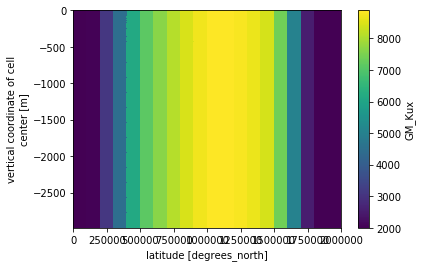

In [44]:
dscoef.GM_Kux.mean(['time','XG']).plot()

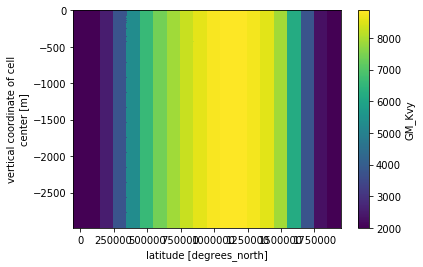

In [40]:
dscoef.GM_Kvy.mean(['time','XC']).plot()

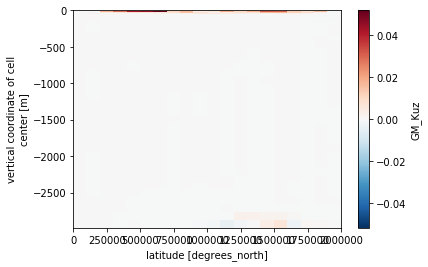

In [42]:
dscoef.GM_Kuz.mean(['time','XG']).plot()

In [ ]:
(dsave.wVeltave[-60:]*86400).mean(['time','XC']).plot()

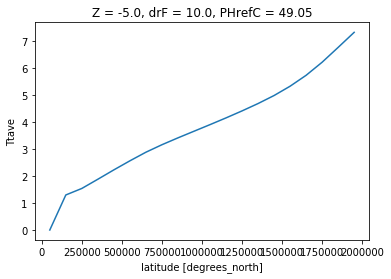

In [45]:
dsave.Ttave[-60:,0].mean(['time','XC']).plot()

In [27]:
grid = Grid(dsave, periodic=['X'])
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

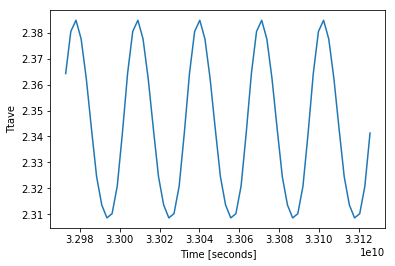

In [28]:
(dsave.Ttave).mean(['Z','YC','XC']).plot()

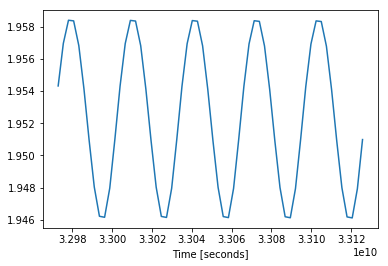

In [29]:
(dsave.Ttave*dsave.drF*np.abs(dsave.Zp1.data[-1])**-1).sum('Z').mean(['YC','XC']).plot()

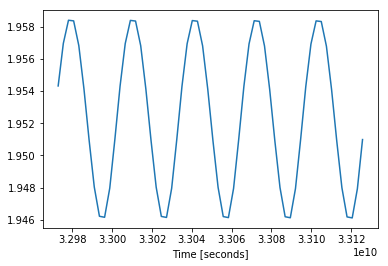

In [30]:
(dsave.Ttave[-1200:]*dsave.drF*np.abs(dsave.Zp1.data[-1])**-1).sum('Z').mean(['YC','XC']).plot()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


[Text(0, 0, 'J'),
 Text(0, 0, 'A'),
 Text(0, 0, 'S'),
 Text(0, 0, 'O'),
 Text(0, 0, 'N'),
 Text(0, 0, 'D'),
 Text(0, 0, 'J'),
 Text(0, 0, 'F'),
 Text(0, 0, 'M'),
 Text(0, 0, 'A'),
 Text(0, 0, 'M'),
 Text(0, 0, 'J')]

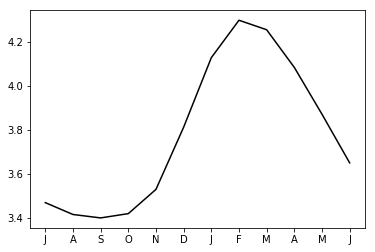

In [31]:
fig, ax = plt.subplots()
ax.plot(range(12), dsave.Ttave[-12:,0].sel(YC=slice(6e5,14e5)).mean(['YC','XC']).roll(time=-6).data, 'k')
ax.set_xticks(range(12))
ax.set_xticklabels(['J','A','S','O','N','D','J','F','M','A','M','J'])

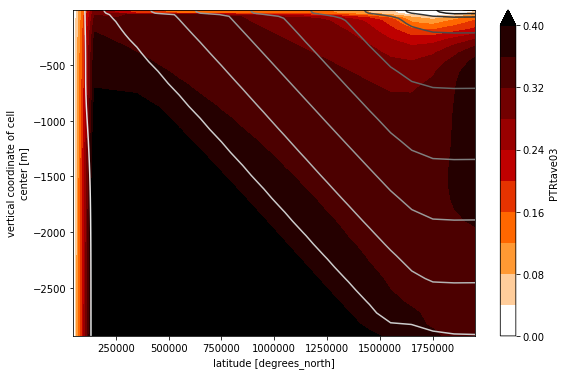

In [33]:
fig,ax = plt.subplots(figsize=(9,6))
(dsave.PTRtave03[-60:].mean(['time','XC'])*1e3).plot.contourf(ax=ax, levels=np.linspace(0,.4,11),
                                                        cmap='gist_heat_r', extend='max')
dsave.Ttave[-60:].mean(['time','XC']).plot.contour(ax=ax, levels=np.linspace(0,7,11),
                                                    cmap='binary', extend='both')

In [75]:
Tave = dsave.Ttave[-120:].mean(['XC'])
with ProgressBar():
    hT = 2*((Tave.mean('time')*dsave.Z*dsave.drF).sum('Z')/(Tave.mean('time')*dsave.drF).sum('Z')).compute()
hT

[########################################] | 100% Completed |  0.3s


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (YC: 20)>
array([       nan, -2787.8784, -2762.0771, -2712.6135, -2640.9817, -2561.0098,
       -2481.9758, -2411.0286, -2354.7302, -2316.112 , -2296.5386, -2294.444 ,
       -2307.1475, -2330.3918, -2360.002 , -2391.5369, -2410.165 , -2418.1626,
       -2414.29  , -2412.936 ], dtype=float32)
Coordinates:
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0

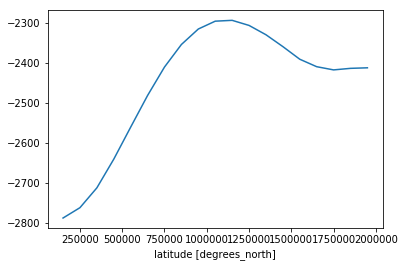

In [76]:
hT.plot()

In [20]:
Uave = dsave.uVeltave.mean(['XG'])
# Uanom = Uave - grid.interp(ug.mean('XC'), 'Y', boundary='fill')
# fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
# Uave[-120:].mean('time').plot(ax=ax1, vmax=.5)
# Uanom[-120:].mean('time').plot(ax=ax2, vmax=.5)

AttributeError: 'Dataset' object has no attribute 'uVeltave'

In [21]:
uC = g*alpha * ((grid.diff(Tave * grid.interp(dsave.dxC,'X').mean('XC'),
                          'Y', boundary='fill')*dsave.rAs.mean('XC')**-1 * dsave.Z
                ).sum('Z') * dsave.dyC.mean('XC')).sum('YG') * f0**-1
uC

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


<xarray.DataArray (time: 120)>
dask.array<shape=(120,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) float64 2.615e+09 2.618e+09 ... 2.921e+09 2.924e+09

In [44]:
uB = np.abs(dsave.Zp1[-1]) * (dsave.uVeltave[:,-1]*dsave.dyG).mean('XG').sum('YC')
uB

<xarray.DataArray (time: 60)>
dask.array<shape=(60,), dtype=float32, chunksize=(1,)>
Coordinates:
    Zp1      >f4 -2985.0
    drC      float64 dask.array<shape=(), chunksize=()>
    PHrefF   >f4 dask.array<shape=(), chunksize=()>
    Z        >f4 -2933.5
    drF      >f4 dask.array<shape=(), chunksize=()>
    PHrefC   >f4 dask.array<shape=(), chunksize=()>
    iter     (time) int64 dask.array<shape=(60,), chunksize=(1,)>
  * time     (time) float64 1.509e+10 1.509e+10 ... 1.524e+10 1.524e+10

In [32]:
with ProgressBar():
    uT = (Uave*dsave.drF*dsave.dyG.mean(['XG'])).sum(['Z','YC']).compute()
# with ProgressBar():
#     uC = (Uanom*dsave.drF*dsave.dyG.mean(['XG'])).sum(['Z','YC']).compute()
# uC

[########################################] | 100% Completed |  1min  4.9s


[Text(1, 0, '74'), Text(1, 0, '74.5'), Text(1, 0, '75')]

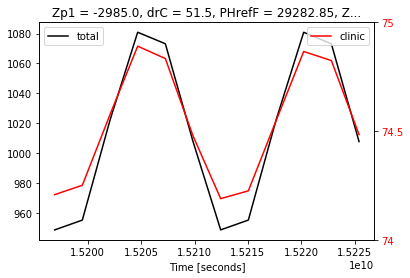

In [47]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
(uT[-18:-6]*1e-6).plot(ax=ax, c='k', label=r'total')
((uT-uB)[-18:-6]*1e-6).plot(ax=ax2, c='r', label=r'clinic')
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
ax2.set_yticks([74,74.5,75])
ax2.set_yticklabels([74,74.5,75], color='r')

In [46]:
ds = open_mdsdataset(op.join(bdir,'100kmMLI_Visdiag'), 
                    grid_dir=op.join(bdir,'100km_grid'), 
                    iters=range(ts+18,te+18,18),
                    prefix=['MOMtave','FeTtave','BIOtave',
                           'KPPboundary'
                           ], delta_t=dt
                    )
ds

OSError: Could not find the expected file prefixes ['MOMtave', 'FeTtave', 'BIOtave', 'KPPboundary'] at iternum 6.86882e+06. (Instead found ['FeTtave', 'BIOtave', 'MOMtave'])

In [100]:
grid = Grid(ds, periodic=['X'])

In [101]:
P1 = ds.TRAC22
P2 = ds.TRAC23
# Z1 = ds.TRAC08
# Z2 = ds.TRAC12
PP = ds.PP
Fe1D = ds.TRAC03

In [102]:
P1.coords['days'] = ('time',np.tile(range(360),dy))
P2.coords['days'] = ('time',np.tile(range(360),dy))
# Z1.coords['days'] = ('time',np.tile(range(360),dy))
# Z2.coords['days'] = ('time',np.tile(range(360),dy))
PP.coords['days'] = ('time',np.tile(range(360),dy))
with ProgressBar():
    P1day = P1.load().groupby('days').median(['time','YC','XC'])
    P2day = P2.load().groupby('days').median(['time','YC','XC'])
#     Z1day = Z1.groupby('days').mean(['time']).compute()
#     Z2day = Z2.groupby('days').mean(['time']).compute()
    PPday = PP.load().groupby('days').median(['time','YC','XC'])

[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s


In [103]:
nz = 8
with ProgressBar():
    P1Cday = (grid.cumsum(P1day*ds.drF,'Z',boundary='fill')[:,nz]
              * np.abs(ds.Zl[nz])**-1*106.*12.).compute()
    P2Cday = (grid.cumsum(P2day*ds.drF,'Z',boundary='fill')[:,nz]
              * np.abs(ds.Zl[nz])**-1*106.*12.).compute()
#     Z1Cday = (grid.cumsum(Z1day*ds.drF,'Z',boundary='fill')[:,nz]
#               * np.abs(ds.Zl[nz])**-1*106.*12.).compute()
#     Z2Cday = (grid.cumsum(Z2day*ds.drF,'Z',boundary='fill')[:,nz]
#               * np.abs(ds.Zl[nz])**-1*106.*12.).compute()
#     P1Cintg = (P1day*ds.drF).sum('Z').compute()
#     P2Cintg = (P2day*ds.drF).sum('Z').compute()
#     Z1Cintg = (Z1day*ds.drF).sum('Z').compute()
#     Z2Cintg = (Z2day*ds.drF).sum('Z').compute()
PtotCday = P1Cday+P2Cday
PPCday = PPday*106.*12.

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [104]:
hbl99 = xr.DataArray(np.percentile(ds.KPPhbl, 99, axis=-1), dims=['time','YC'],
                    coords={'time':ds.time,'YC':ds.YC})
hbl99.coords['day'] = ('time',np.tile(range(360),dy))
hbl99.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
hbl99.coords['month'] = ('time',np.tile(np.repeat(range(12),30),dy))
hbl99.to_dataset(name='hbl99').to_netcdf(op.join(bdir,'KPPhbl_99percentile_100kmMLI-02km_GMR5000.nc'))
# hbl99 = xr.open_dataset(op.join(bdir,'KPPhbl_99percentile_20kmMLI-Ce007_Tau55-02km.nc'), 
#                         decode_times=False).hbl99
with ProgressBar():
    hbl99_day = hbl99.groupby('day').mean('time').compute()
# #     hbl99_sea = hbl99.groupby('seas').mean('time').compute()
# #     hbl99_mon = hbl99.groupby('month').mean('time').compute()
hbl99_day

<xarray.DataArray (day: 360, YC: 20)>
array([[ 0., 30., 30., ..., 30., 30., 30.],
       [ 0., 30., 30., ..., 30., 30., 30.],
       [ 0., 30., 30., ..., 30., 30., 30.],
       ...,
       [ 0., 30., 30., ..., 30., 30., 30.],
       [ 0., 30., 30., ..., 30., 30., 30.],
       [ 0., 30., 30., ..., 30., 30., 30.]])
Coordinates:
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * day      (day) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

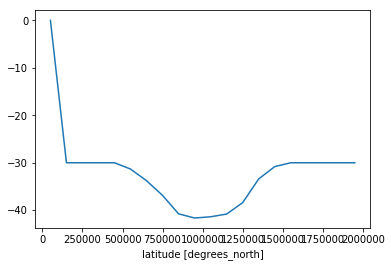

In [57]:
(-hbl99).mean(['time']).plot()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


[Text(0, 0, 'J'),
 Text(0, 0, 'A'),
 Text(0, 0, 'S'),
 Text(0, 0, 'O'),
 Text(0, 0, 'N'),
 Text(0, 0, 'D'),
 Text(0, 0, 'J'),
 Text(0, 0, 'F'),
 Text(0, 0, 'M'),
 Text(0, 0, 'A'),
 Text(0, 0, 'M'),
 Text(0, 0, 'J')]

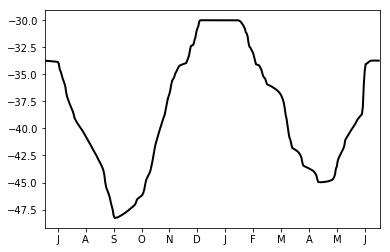

In [105]:
fig, ax = plt.subplots()
ax.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180).data, 
       lw=2, color='k')
ax.set_xticks(range(14,360,30))
ax.set_xlim([0,360])
ax.set_xticklabels(['J','A','S','O','N','D','J','F','M','A','M','J'])

In [48]:
dsnap = open_mdsdataset(op.join(bdir,'100kmMLI_GMR5000'), 
                       grid_dir=op.join(bdir,'100km_grid'), iters=range(ts,te,270),
                       prefix=['W','PTRACER03',
#                               'PTRACER26'
                              ], delta_t=dt
                       )
dsmon = open_mdsdataset(op.join(bdir,'100kmMLI_GMR5000'), 
                       grid_dir=op.join(bdir,'100km_grid'), iters=range(ts+540,te+540,540),
                       prefix=['wVeltave','PTRtave03',
#                               'PTRtave26'
                              ], delta_t=dt
                       )
wsp = dsnap.W
Fesp = dsnap.PTRACER03
# POCsp = dsnap.PTRACER26
wm = dsmon.wVeltave
Fem = dsmon.PTRtave03
# POCm = dsmon.PTRtave26
print(wsp,wm)

OSError: Could not find the expected file prefixes ['W', 'PTRACER03'] at iternum 6.8688e+06. (Instead found [])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


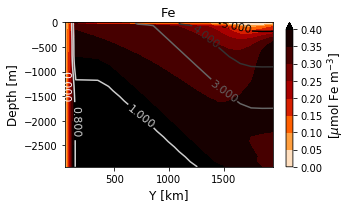

In [52]:
tlevs = np.array([0,.8,1,3,4,5])
fig, ax = plt.subplots(figsize=(5,3))
fig.set_tight_layout(True)
im = ax.contourf(dsave.YC*1e-3, dsave.Z, dsave.PTRtave03[-60:].mean(['time','XC'])*1e3,
               levels=np.linspace(0,.4,9), extend='max', cmap = 'gist_heat_r')
cs = ax.contour(dsave.YC*1e-3, dsave.Z, dsave.Ttave[-60:].mean(['time','XC']), 
              levels=tlevs, cmap='binary')
for c in im.collections:
    c.set_rasterized(True)
for c in cs.collections:
    c.set_rasterized(True)
ax.set_title(r"Fe", fontsize=13)
ax.set_ylabel(r"Depth [m]", fontsize=12)
ax.set_xlabel(r"Y [km]", fontsize=12)
ax.set_ylim([dsave.Z[-1],0])
plt.clabel(cs, inline=1, fontsize=11)
cb = fig.colorbar(im, ax=ax)
cb.set_label(r"[$\mu$mol Fe m$^{-3}$]",fontsize=12)
plt.savefig(op.join(bdir,'Figures/Fe-transect_100km-Vis.pdf'))

In [108]:
diff = ds.DFrITr03+ds.DFrETr03
advW = ds.ADVrTr03
dfz_cons = diff/(ds.rA)
adz_cons = advW/(ds.rA)
dfz_cons.coords['day'] = ('time',np.tile(range(360),dy))
adz_cons.coords['day'] = ('time',np.tile(range(360),dy))
wsp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
Fesp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
wm.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
Fem.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
# POCsp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
# POCm.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
wp = wsp.groupby('seas') - wm.groupby('seas').mean(['time','XC'])
Fep = Fesp.groupby('seas') - Fem.groupby('seas').mean(['time','XC'])
# POCp = POCsp.groupby('seas') - POCm.groupby('seas').mean(['time','XC'])

In [109]:
wpFep = wp*grid.interp(Fep,'Z',boundary='fill')
wpFep.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    dfz_c = dfz_cons.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
#     adz_c = adz_cons.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
    wpFep_d = wpFep.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()

[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  2.8s


In [110]:
dsGM = open_mdsdataset(op.join(bdir,'100kmMLI_GMR5000diag'),
                      grid_dir=op.join(bdir,'100km_grid'), iters=range(ts,te,270),
                      prefix=['GMpsi15D',
                             ], delta_t=dt
                      )
dsGM

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:  (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 120)
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * XG       (XG) >f4 0.0 100000.0 200000.0 ... 700000.0 800000.0 900000.0
  * YG       (YG) >f4 0.0 100000.0 200000.0 ... 1700000.0 1800000.0 1900000.0
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2676.0 -2779.0 -2882.0 -2985.0
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA       (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG      (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG      (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth    (YC, XC) >f4 dask.array<shape=

In [111]:
gridGM = Grid(dsGM, periodic=['X'])
Psiyk = xrft.dft(dsGM.GM_PsiY, dim=['XC'], shift=False)
Psiy_x = dsar.fft.ifft((Psiyk*1j*2*np.pi*Psiyk.freq_XC).data, axis=-1).compute()
Psiy_x = gridGM.interp(xr.DataArray(Psiy_x.real, dims=dsGM.GM_PsiY.dims, coords=dsGM.GM_PsiY.coords),
                      'Y', boundary='fill')
with ProgressBar():
    wGM = (Psiy_x - gridGM.interp(gridGM.interp(gridGM.diff(dsGM.GM_PsiX*dsGM.dxC,'Y',boundary='fill')
                                               / dsGM.rAz,
                                               'Y',boundary='fill'),
                                 'X')
          ).compute()
wGM

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


[########################################] | 100% Completed |  3.1s


<xarray.DataArray (time: 120, Zl: 40, YC: 20, XC: 10)>
array([[[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 0.000000e+00, ...,  0.000000e+00]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 2.878928e-23, ..., -3.003828e-23]]],


       ...,


       [[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 0.000000e+00, ...,  0.000000e+00]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [-8.813817e-23, ...,  8.766454e-23]]]])
Coordinates:
  * time     (time) float64 1.54e+10 1.54e+10 1.54e+10 ... 1.555e+10 1.555e+10
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * XC       (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0

In [112]:
wGMFe_adv = wGM*grid.interp(Fesp,'Z',boundary='fill')
wGMFe_adv.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    wGMFe_advd = wGMFe_adv.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
wGMFe_advd

[########################################] | 100% Completed |  1.8s


<xarray.DataArray (day: 24, Zl: 40)>
array([[ 0.000000e+00,  9.871711e-28,  1.025022e-27, ...,  1.340167e-29,
        -1.037123e-28,  4.158903e-28],
       [ 0.000000e+00,  9.993124e-28,  1.019601e-27, ...,  1.485589e-29,
        -1.148477e-28,  4.277637e-28],
       [ 0.000000e+00,  6.770983e-28,  6.907130e-28, ...,  1.874439e-29,
        -1.275768e-28,  4.354171e-28],
       ...,
       [ 0.000000e+00, -6.881366e-27, -6.807785e-27, ...,  8.233306e-30,
        -8.220199e-29,  3.665446e-28],
       [ 0.000000e+00, -5.604921e-29, -1.236951e-29, ...,  8.693871e-30,
        -8.653617e-29,  3.741304e-28],
       [ 0.000000e+00,  1.360703e-28,  1.535980e-28, ...,  9.389811e-30,
        -9.251718e-29,  3.855725e-28]])
Coordinates:
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [113]:
Fe1D = ds.TRAC03
Fe1D.coords['day'] = ('time',np.tile(np.roll(range(360),0),dy))
with ProgressBar():
    Fe_c = Fe1D.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
Fe_c

[########################################] | 100% Completed |  5.2s


<xarray.DataArray 'TRAC03' (day: 360, Z: 40)>
array([[5.093735e-06, 5.032458e-06, 4.989256e-06, ..., 3.254668e-04,
        3.279854e-04, 3.302227e-04],
       [5.153274e-06, 5.091657e-06, 5.047038e-06, ..., 3.254689e-04,
        3.279872e-04, 3.302262e-04],
       [5.210355e-06, 5.148379e-06, 5.102399e-06, ..., 3.254710e-04,
        3.279890e-04, 3.302297e-04],
       ...,
       [4.896678e-06, 4.834156e-06, 4.795118e-06, ..., 3.261768e-04,
        3.284740e-04, 3.305808e-04],
       [4.962673e-06, 4.899861e-06, 4.859209e-06, ..., 3.261787e-04,
        3.284757e-04, 3.305842e-04],
       [5.026950e-06, 4.963845e-06, 4.921664e-06, ..., 3.261807e-04,
        3.284775e-04, 3.305875e-04]], dtype=float32)
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0 103.0
    PHrefC   (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
  * day      (day) int64 0 1 2 3 4 5 6 7 8

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


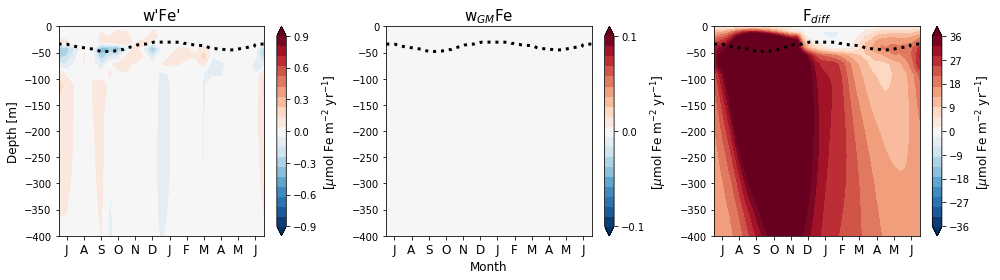

In [114]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(range(0,346,15), wpFep_d.Zl, wpFep_d.roll(day=-12).T*1e3*360*86400, 
                  levels=np.linspace(-.9,.9,20), 
                   cmap='RdBu_r', extend='both')
ax1.contourf(range(14,360,15), wpFep_d.Zl, wpFep_d.roll(day=-13).T*1e3*360*86400, 
            levels=np.linspace(-.9,.9,20), 
             cmap='RdBu_r', extend='both')
im2 = ax2.contourf(range(0,346,15), wGMFe_advd.Zl, wGMFe_advd.roll(day=-12).T*1e3*360*86400,
                  levels=1e-0*np.linspace(-.1,.1,20), 
                  extend='both', cmap='RdBu_r')
ax2.contourf(range(14,360,15), wGMFe_advd.Zl, wGMFe_advd.roll(day=-13).T*1e3*360*86400,
            levels=1e-0*np.linspace(-.1,.1,20), 
            extend='both', cmap='RdBu_r')
# im3 = ax3.contourf(range(360), Fe_c.Z, Fe_c.roll(day=-180).T*1e3, 
#                   levels=np.linspace(0,.3,11), cmap='OrRd', extend='max')
im3 = ax3.contourf(range(360), dfz_c.Zl, dfz_c.T.roll(day=-180)*1e3*(360*86400), 
                  levels=np.linspace(-36,36,20), 
                  cmap='RdBu_r', extend='both')
ax1.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax2.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax3.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax1.set_title(r"w'Fe'", fontsize=15)
ax2.set_title(r"w$_{GM}$Fe", fontsize=15)
ax3.set_title(r"F$_{diff}$", fontsize=15)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"Month", fontsize=12)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_ylim([-400,0])
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_ylim([-400,0])
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_ylim([-400,0])
# fig.colorbar(im1, ax=ax1, ticks=[-10,-7.5,-5.,-2.5,0,2.5,5.,7.5,10])
# fig.colorbar(im2, ax=ax2, ticks=[-.8,-.6,-.4,-.2,0,.2,.4,.6,.8])
# cbar = fig.colorbar(im3, ax=ax3, ticks=[0,6,12,18,24,30])
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.16, 0.014, 0.68])
# cbar = fig.colorbar(im3, cax=cbar_ax, ticks=[-10,-8,-6,-4,-2,0,2,4,6,8,10])
# cbar.set_label(r'[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]', fontsize=12)
cbar1 = fig.colorbar(im1, ax=ax1, 
                    ticks=[-.9,-.6,-.3,0,.3,.6,.9]
                    )
cbar2 = fig.colorbar(im2, ax=ax2, 
                    ticks=[-.1,-.75,-.5,-.25,0,.25,.5,.75,.1]
                    )
cbar3 = fig.colorbar(im3, ax=ax3, 
                    ticks=[-36,-27,-18,-9,0,9,18,27,36]
                    )
cbar1.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
cbar2.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
cbar3.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
plt.savefig(op.join(bdir,'Figures/VerticalFeflux_100kmMLI-02km_GM5000.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


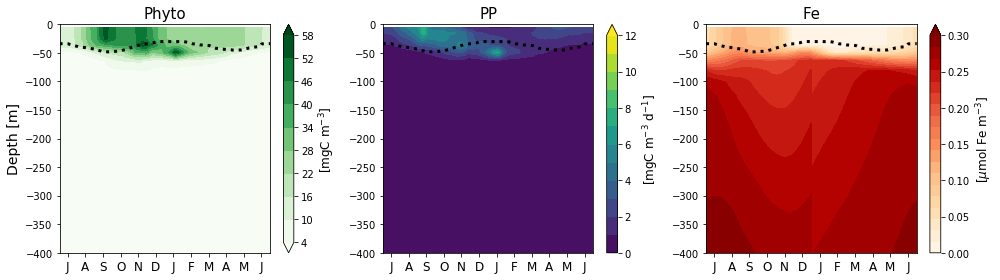

In [115]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig, (ax1,ax3,ax5) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.set_tight_layout(True)
# im1 = ax1.contourf(range(360), w2_sqrt.Zl, w2_sqrt.T.roll(day=-180)*86400, 
#                   levels=np.linspace(1,20.,11), cmap='Reds', extend='both')
# im2 = ax2.contourf(range(360), dbdz_d.Z, dbdz_d.T.roll(days=-180), 
#                   levels=np.linspace(-4e-5,4e-5,21), cmap='RdBu_r', extend='both')
# im1 = ax1.contourf(range(360), dFedz_d.Zl, dFedz_d.T.roll(days=-180)*1e3, 
#                   levels=np.linspace(0,.002,21), cmap='Oranges', extend='both')
# ax1.plot(range(360), ZFe_d.roll(days=-180), 'k:')
im1 = ax1.contourf(range(360), (P1day + P2day).Z, (P1day + P2day).T.roll(days=-180)*106.*12., 
                  levels=np.linspace(4,58,10), cmap='Greens', extend='both')
im3 = ax3.contourf(range(360), PPCday.Z, PPCday.T.roll(days=-180)*86400., 
                  levels=np.arange(0,13,1), extend='max')
im5 = ax5.contourf(range(360), Fe_c.Z, Fe_c.T.roll(day=-180)*1e3,
                  levels=np.linspace(0,0.3,20), 
                   extend='max', cmap='OrRd')
# ax1.contour(range(0,360,15), wpbp_d.Zl, wpbp_d.T.roll(days=-12), colors='k', levels=np.linspace(2e-9,2e-8,8))
# ax2.contour(range(0,360,15), wpbp_d.Zl, wpbp_d.T.roll(days=-12), colors='k', levels=np.linspace(2e-9,2e-8,8))
# ax3.pcolormesh(range(360), dfz_c.Zl, ((dfz_c-adz_c)/diff_M).T.roll(days=-180), 
#                vmax=1, vmin=-1., cmap='RdBu_r', norm=SymLogNorm(0.01), rasterized=True)
ax1.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax5.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax3.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
# ax1.set_ylim([-4e2,0])
# ax2.set_ylim([-5e2,0])
ax1.set_ylim([-4e2,0])
ax3.set_ylim([-4e2,0])
ax5.set_ylim([-4e2,0])
# ax2.set_xlim([0,359])
# ax2.set_title(r"db$/$dz", fontsize=14)
ax1.set_title(r"Phyto", fontsize=15)
# ax1.set_title(r"dFe$/$dz", fontsize=15)
ax3.set_title(r"PP", fontsize=15)
ax5.set_title(r"Fe", fontsize=15)
# ax1.set_xticks(np.linspace(14,344,12))
# ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
# ax2.set_xticks(np.linspace(14,344,12))
# ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax5.set_xticks(np.linspace(14,344,12))
ax5.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=14)
# ax2.set_xlabel(r"Month", fontsize=13)
# fig.subplots_adjust(right=0.88)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar1 = fig.colorbar(im1, ax=ax1, ticks=1e-4*np.array([0,4,8,12,16,20]))
# fig.colorbar(im2, ax=ax2)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar3 = fig.colorbar(im3, ax=ax3)
cbar5 = fig.colorbar(im5, ax=ax5, ticks=[0,0.05,0.1,0.15,0.2,0.25,0.3])
cbar5.set_label(r"[$\mu$mol Fe m$^{-3}$]", fontsize=12)
cbar3.set_label(r"[mgC m$^{-3}$ d$^{-1}$]", fontsize=12)
# cbar1.set_label(r"[$\mu$mol Fe m$^{-4}$]", fontsize=12)
cbar1.set_label(r"[mgC m$^{-3}$]", fontsize=12)
plt.savefig(op.join(bdir,'Figures/P-PP-Fe_dailyclimatology_100km_XLIGM5000.pdf'))